# Deadline: April 28th, 11:59 PM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Semantic Segmentation and Instance Segmentation Assignment

Run the next cell ONLY IF YOU ARE USING COLAB:

In [ ]:
!gdown --id 1wzAVGdHnNepfBBDpRO2EmHiqqFfxpOGp
!unzip colab.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wzAVGdHnNepfBBDpRO2EmHiqqFfxpOGp
To: /content/colab.zip
100% 187k/187k [00:00<00:00, 97.5MB/s]
Archive:  colab.zip
   creating: segmentation_splits/
  inflating: segmentation_splits/train.txt  
  inflating: segmentation_splits/test.txt  
  inflating: segmentation_splits/val.txt  
  inflating: baboon.jpg              
  inflating: data_utils.py           
  inflating: download_datasets.sh    
  inflating: segmentation_nn.py      
  inflating: solver.py               
  inflating: vis_utils.py            


# A) Warm-Up (10 pts)



There are different interpolation types to upsample an image, such as nearest, linear, bilinear, bicubic... In this question, an original size baboon image, and a downsampled baboon image is provided. Interpolate the downsampled image with different modes, visualize them.

Typically, PSNR and SSIM metrics are used to evaluate the quality of a compressed/decompressed image. We can use them to measure the interpolation quality.


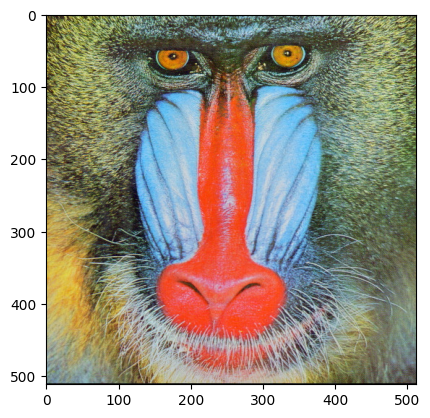

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('baboon.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

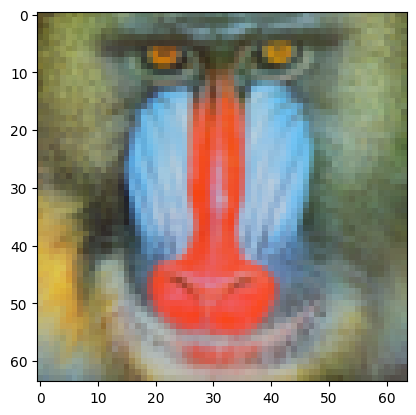

In [ ]:
from skimage import data, color, img_as_float
from skimage.transform import rescale, resize

img = img_as_float(img)
image_resized = resize(img, (img.shape[0] // 8, img.shape[1] // 8))

plt.imshow(image_resized)

In [ ]:
import torch
import torch.nn

img_tensor = torch.from_numpy(image_resized.transpose(2,0,1)).unsqueeze(0)

scale_factor = 8

# TODO: Use interpolation function torch.nn.functional to upsample images with different modes.
img_nearest = torch.nn.functional.interpolate(img_tensor, scale_factor=scale_factor, mode='nearest')
img_bilinear = torch.nn.functional.interpolate(img_tensor,scale_factor=scale_factor,mode='bilinear')
img_bicubic = torch.nn.functional.interpolate(img_tensor,scale_factor=scale_factor,mode='bicubic')

# TODO: Convert images back to numpy.
img_nearest_np = img_nearest.squeeze(0).permute(1,2,0).numpy()
img_bilinear_np =img_bilinear.squeeze(0).permute(1,2,0).numpy()
img_bicubic_np =img_bicubic.squeeze(0).permute(1,2,0).numpy()

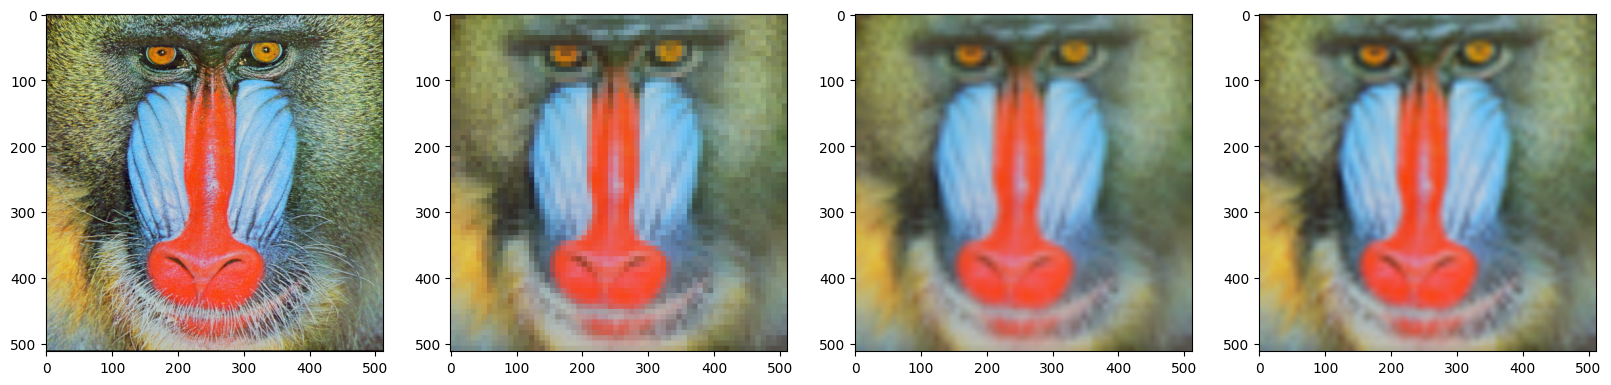

In [ ]:
# Visualization of images
f, axarr = plt.subplots(1,4,figsize=(20,20))
axarr[0].imshow(img)
axarr[1].imshow(img_nearest_np)
axarr[2].imshow(img_bilinear_np)
axarr[3].imshow(img_bicubic_np)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# TODO: calculate the PSNR and SSIM scores between original image and upsampled
# version. Do these scores align with the visualizations?
psnr_nearest=psnr(img,img_nearest_np)
psnr_bilinear=psnr(img,img_bilinear_np)
psnr_bicubic=psnr(img,img_bicubic_np)
ssim_nearest=ssim(img,img_nearest_np,multichannel=True)
ssim_bilinear=ssim(img,img_bilinear_np,multichannel=True)
ssim_bicubic=ssim(img,img_bicubic_np,multichannel=True)

print("PSNR and SSIM scores for nearest interpolation:")
print(f"PSNR: {psnr_nearest}, SSIM: {ssim_nearest}")

print("PSNR and SSIM scores for bilinear interpolation:")
print(f"PSNR: {psnr_bilinear}, SSIM: {ssim_bilinear}")

print("PSNR and SSIM scores for bicubic interpolation:")
print(f"PSNR: {psnr_bicubic}, SSIM: {ssim_bicubic}")

#greater psnr and ssim scores means better quality of image
#we can see bicubic>bilinear>nearest, and when we check the images, that true.
#so yes, scores align with visualizations.

<ipython-input-7-1d33ce72316b>:9: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nearest=ssim(img,img_nearest_np,multichannel=True)
<ipython-input-7-1d33ce72316b>:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_bilinear=ssim(img,img_bilinear_np,multichannel=True)
<ipython-input-7-1d33ce72316b>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_bicubic=ssim(img,img_bicubic_np,multichannel=True)


PSNR and SSIM scores for nearest interpolation:
PSNR: 19.107352326992938, SSIM: 0.43215310264632834
PSNR and SSIM scores for bilinear interpolation:
PSNR: 19.217285842720976, SSIM: 0.4444279513220453
PSNR and SSIM scores for bicubic interpolation:
PSNR: 19.419787077134643, SSIM: 0.45538129891364343


# B) Fully Convolutional Network for Semantic Segmentation (45 pts)

In this exercise, we will implement a neural network for semantic segmentation, and train and test the results with the provided dataset. As it would take a long time to train the whole network, we'll finetune the model by reusing a pretrained backbone model (eg. VGG16). You can influence from FCN, which is one of the first architectures proposed for semantic segmentation [1](https://arxiv.org/pdf/1411.4038.pdf).

We provide a skeleton code which should be filled in respectively. The dataloaders and utilization codes are also provided.


## MSRC-v2 Segmentation Dataset


We'll use the MSRC dataset for this exercise, which contains 591 images and 23 different semantic labels. The training is done on 443 images, validation on 74 and testing on 74 images. More info about the labels can be found on "info.html".

To get the dataset run the commands below to directly get them into the notebook.

In [ ]:
!wget http://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
!unzip msrc_objcategimagedatabase_v2.zip

--2024-04-23 13:09:47--  http://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.192.208.155, 2600:1409:9800:48e::317f, 2600:1409:9800:480::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.192.208.155|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip [following]
--2024-04-23 13:09:47--  https://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.192.208.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115962745 (111M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v2.zip’

msrc_objcategimaged 100%[===================>] 110

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from segmentation_nn import SegmentationNN
from data_utils import SegmentationData, label_img_to_rgb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
train_data = SegmentationData(image_paths_file='segmentation_splits/train.txt')
val_data = SegmentationData(image_paths_file='segmentation_splits/val.txt')

Train size: 443
Validation size: 74
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


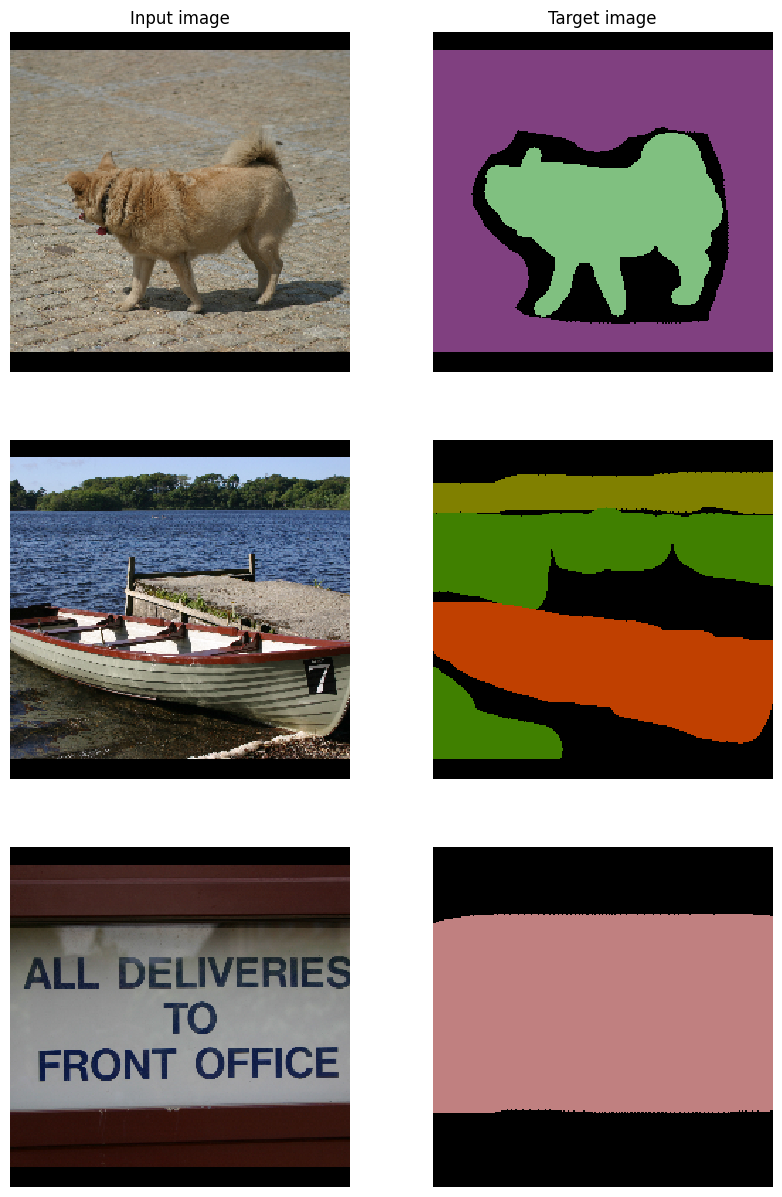

In [ ]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")

    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

## Part 1: Implement and Train the Network (25 pts)

Let's implement the neural network by filling up the necessary parts in `segmentation_nn.py`. It will take an input of size (N, C, H, W) and output (N, num_classes, H, W). As a pretrained backbone, you can use the VGG16 network from torchvision library, or any other backbone you wish. Start with a simple model where you take the feature layer from VGG, and introduce several layers which end up with segmentation predictions (FCN32 might be an example).


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

## This is provided for debugging! After implementing the network, put it into
## the "segmentation_nn.py" file.

class FCN(nn.Module):

    def __init__(self, num_classes=23):
        super(FCN, self).__init__()

        model = models.vgg16(pretrained= True)

    def forward(self, x):
      pass


For training, we provide the skeleton `solver.py` code. Fill in the given code for training and evaluation. The dataloaders are already provided, and you need to code up the optimization process. As for the loss, we can go with the typical `CrossEntropyLoss`. Note that there are some `unlabeled` classes in the dataset. These pixels should not be considered in the loss nor in the accuracy of the segmentation.

In [ ]:
from segmentation_nn import SegmentationNN
from solver import Solver
import torch.nn.functional as F


########################################################################
#                             YOUR CODE                                #
########################################################################
# Tip: You can freeze the backbone
# Tip: Try overfitting the network first, for a single sample.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True, num_workers=4)

model = SegmentationNN().cuda() if torch.cuda.is_available() else SegmentationNN()

for param in model.features.parameters():
    param.requires_grad = False
solver = Solver()

#single_sample_train_loader = torch.utils.data.DataLoader(train_data[:1], batch_size=1, shuffle=False)
#single_sample_val_loader = torch.utils.data.DataLoader(val_data[:1], batch_size=1, shuffle=False)

epoch = 10
model = solver.train(model, train_loader, val_loader, num_epochs=10, log_nth = 1)

START TRAIN.
[Iteration 1/450] TRAIN loss: 3.3463, acc: 0.0389
[Iteration 2/450] TRAIN loss: 3.0939, acc: 0.2070
[Iteration 3/450] TRAIN loss: 2.9319, acc: 0.3270
[Iteration 4/450] TRAIN loss: 2.8247, acc: 0.3440
[Iteration 5/450] TRAIN loss: 2.7962, acc: 0.3160
[Iteration 6/450] TRAIN loss: 2.7570, acc: 0.3431
[Iteration 7/450] TRAIN loss: 2.6743, acc: 0.4869
[Iteration 8/450] TRAIN loss: 2.6035, acc: 0.4943
[Iteration 9/450] TRAIN loss: 2.5209, acc: 0.5365
[Iteration 10/450] TRAIN loss: 2.4949, acc: 0.3864
[Iteration 11/450] TRAIN loss: 2.4699, acc: 0.3972
[Iteration 12/450] TRAIN loss: 2.4097, acc: 0.6552
[Iteration 13/450] TRAIN loss: 2.3343, acc: 0.6912
[Iteration 14/450] TRAIN loss: 2.2970, acc: 0.5277
[Iteration 15/450] TRAIN loss: 2.2578, acc: 0.5246
[Iteration 16/450] TRAIN loss: 2.2191, acc: 0.5739
[Iteration 17/450] TRAIN loss: 2.1942, acc: 0.5480
[Iteration 18/450] TRAIN loss: 2.1609, acc: 0.5953
[Iteration 19/450] TRAIN loss: 2.1165, acc: 0.6680
[Iteration 20/450] TRAIN lo

In [ ]:
# Save the model
model.save("segmentation_nn.pth")

Saving model... segmentation_nn.pth


## Part 2: Test the Model (10 pts)

We will report the pixel accuracy and IoU metric for the trained model.
First, implement the Intersection over Union segmentation metric to measure the segmentation accuracy for the trained model.

You will use this function in the next cell.

In [ ]:
n_class = 23

def iou(pred, target):
    ious = []
    for cls in range(0, n_class):

        intersection = None
        union = None

        ## TODO: Calculate intersection and union for each class
        intersection = (pred == cls) & (target == cls)
        union = (pred == cls) | (target == cls)

        intersection = intersection.sum()
        union = union.sum()



        #########################################################
        if union == 0: # if there is no ground truth, do not include in evaluation
            pass

        else:   # calculate class iou
            #########################################################

            iou_cls = intersection / union
            ious.append(iou_cls)

            #########################################################

    return np.nanmean(ious)

Your model should result with a pixel accuracy of more than 60%.
The IoU should be more than 20%.

In [ ]:
test_data = SegmentationData(image_paths_file='segmentation_splits/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

unlabeled_class_index = -1
test_scores = []
total_ious = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets)

    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    # Retrieve the predictions
    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)
    ##########
    mask = (targets != unlabeled_class_index)
    preds_masked = preds[mask]
    targets_masked = targets[mask]
    ########
    correct_pixels = torch.eq(preds_masked, targets_masked)
    test_score = torch.mean(correct_pixels.float())
    test_scores.append(test_score.item())

    # Calculate IoU
    total_ious.append(iou(preds.cpu().numpy(), targets.cpu().numpy()))


print("Test accuracy: ", np.mean(test_scores))
print("Test IoU: ", np.nanmean(total_ious))

Test accuracy:  0.8530200432885338
Test IoU:  0.30644729929673536


## Part 3: Visualize the Results (5 pts)


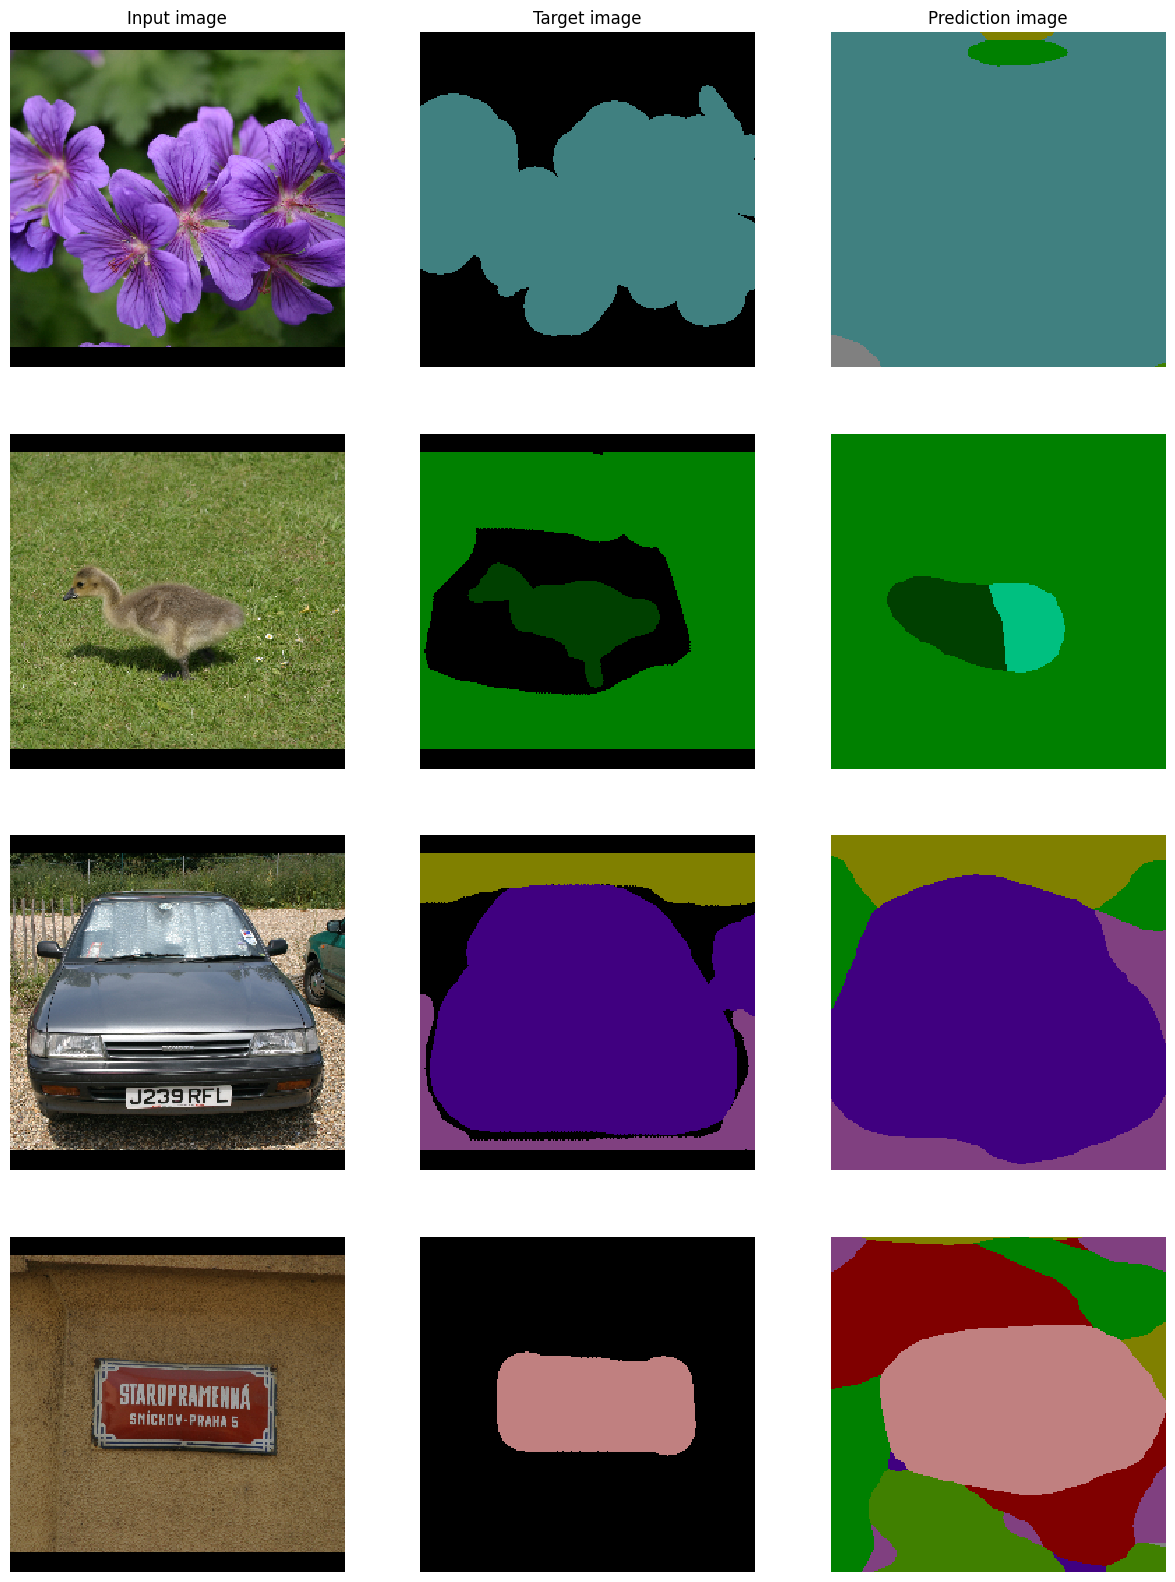

In [ ]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()

    ## TODO: Retrieve the predictions.

    outputs = model(inputs)

    _, pred = torch.max(outputs, 1)


    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.numpy().transpose(1,2,0)) #i added .numpy() dont forget
    if i == 0:
        plt.title("Input image")

    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target.numpy()))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred.cpu()))
    if i == 0:
        plt.title("Prediction image")

plt.show()

## Part 4: Visualize Filter Weights (5 pts)
You can visualize the convolutional filters of the very first layer. Each kernel provides the structures of edges, corners and circles.


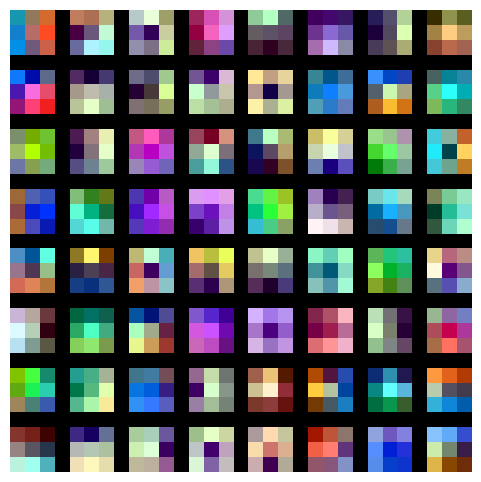

In [ ]:
from vis_utils import visualize_grid

# TODO: get the first (next) convolutional parameter
conv_params = None
conv_params = model.features[0].weight.detach().cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# C) Object Detection to Instance Segmentation: Faster R-CNN to Mask R-CNN. (35 pts)

You have learnt about **Faster R-CNN** [12]  when object detection was covered. Remember that Faster R-CNN [12] predicts bounding boxes and class scores for potential objects in the image.

**Mask R-CNN** [6] adds an extra branch into Faster R-CNN [12], which also predicts segmentation masks for each instance.

<img src="https://pythonawesome.com/content/images/2018/07/Mask-RCNN.png" alt="Mask R-CNN" width="500">

You will implement this extra branch, train the model, test it, and visualize the results. You will use PennFudan [7] dataset.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0mftk4e3
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0mftk4e3
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375612 sha256=e3a2154c43fbd6bad3d7ea8fc5906a36d9af9aa170ee18cbd4a9f8e5402bcbf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-m3iuovv6/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2024-04-23 13:27:43--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  26.3MB/s    in 1.9s    

2024-04-23 13:27:45 (26.3 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2024-04-23 13:27:45--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2024-04-23 13:27:45--
Total wall clock time: 2.3s
Downloaded: 1 files, 51M in 1.9s (26.3 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

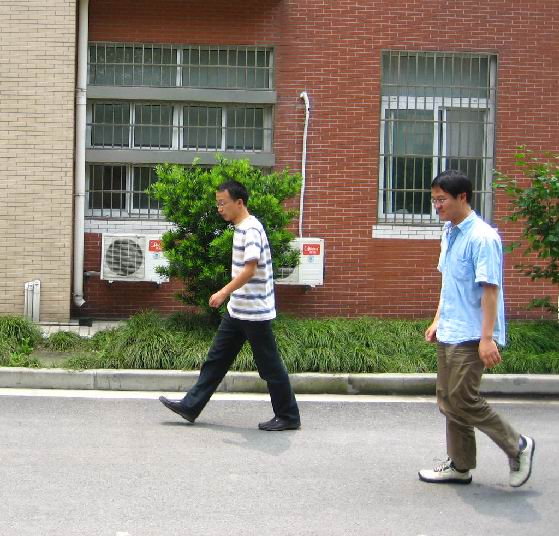

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

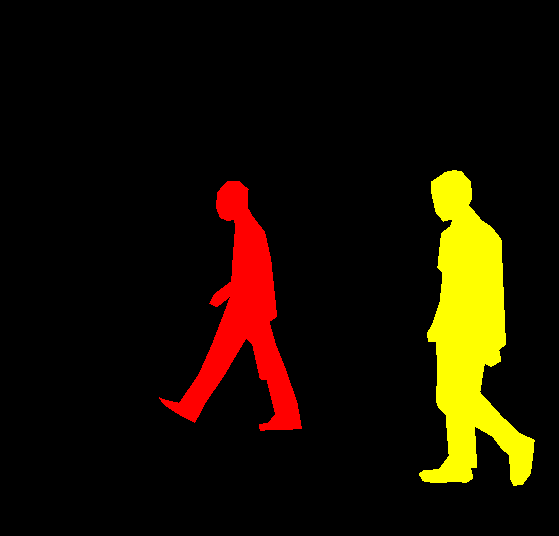

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask = mask.convert("P")

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

You can find how dataset for PennFudan [7] looks like below.
## Question 1 (7.5 pts)
Given masks in an image in the dataset, find the bounding box coordinates of a mask.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            ##################################################################
            ###                      YOUR CODE STARTS                      ###
            ##################################################################
            # TODO: Given the masks, find the bounding box coordinate for each
            # image and append to 'boxes'. See [8] for how bounding box
            # coordinates are represented.


            pos=np.where(masks[i])
            xmin=np.min(pos[1])
            ymin=np.min(pos[0])
            xmax=np.max(pos[1])
            ymax=np.max(pos[0])
            boxes.append([xmin,ymin,xmax,ymax])

            ##################################################################
            ###                       YOUR CODE ENDS                       ###
            ##################################################################

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            #img, target = self.transforms(img, target)
             img= self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 496749, done.
remote: Counting objects: 100% (10359/10359), done.
remote: Compressing objects: 100% (564/564), done.
remote: Total 496749 (delta 9792), reused 10322 (delta 9777), pack-reused 486390
Receiving objects: 100% (496749/496749), 961.96 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (463027/463027), done.
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


## Question 2 (5 pts)
Implement transformations for images. (Keeping in mind our task and dataset, use appropriate data augmentations)

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import torchvision.transforms as T

##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################
# TODO: train_transform should convert image into a PyTorch tensor, then apply
# at least one two transformation for data augmentation
def train_transform():
    transforms = [T.ToTensor(), T.RandomHorizontalFlip(0.5)]
    return T.Compose(transforms)

# TODO: test_transform should convert image into a PyTorch tensor
def test_transform():
    transforms = [T.ToTensor()]
    return T.Compose(transforms)
##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', train_transform())
dataset_test = PennFudanDataset('PennFudanPed', test_transform())

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Question 3 (10 pts)
<img src="https://vipulvaibhaw.files.wordpress.com/2019/04/screenshot-2019-04-20-at-8.34.16-am.png?w=1100" alt="Mask R-CNN detailed" width="500">

Mask R-CNN [6] proposes two heads for mask detection. We have implemented below the one on the right (w/ FPN) on top of a pretrained Faster R-CNN [12]. You can find Figure 4 in [6] for the details of the network.

In [ ]:
import torchvision
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#Defining ROI Align.
mask_roi_pool = torchvision.ops.MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=14,
                sampling_ratio=2)

#Adding head
mask_head = nn.Sequential(
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
        )

#Adding predictor
mask_predictor = nn.Sequential(
          nn.ConvTranspose2d(256, 256, 2, 2, 0),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 91, 1, 1, 0)
        )


my_mask = fasterrcnn
my_mask.roi_heads.mask_roi_pool = mask_roi_pool
my_mask.roi_heads.mask_head = mask_head
my_mask.roi_heads.mask_predictor = mask_predictor

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = my_mask
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Construct an optimizer.

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = None
##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

In [ ]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 25 epochs
num_epochs = 25

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:01  lr: 0.000018  loss: 1.1735 (1.1735)  loss_classifier: 0.1926 (0.1926)  loss_box_reg: 0.2499 (0.2499)  loss_mask: 0.6927 (0.6927)  loss_objectness: 0.0120 (0.0120)  loss_rpn_box_reg: 0.0263 (0.0263)  time: 1.0283  data: 0.3079  max mem: 3385
Epoch: [0]  [10/60]  eta: 0:00:32  lr: 0.000187  loss: 0.9295 (0.9958)  loss_classifier: 0.0974 (0.1216)  loss_box_reg: 0.1283 (0.1355)  loss_mask: 0.6927 (0.6925)  loss_objectness: 0.0072 (0.0352)  loss_rpn_box_reg: 0.0117 (0.0109)  time: 0.6482  data: 0.0369  max mem: 3480
Epoch: [0]  [20/60]  eta: 0:00:24  lr: 0.000357  loss: 0.9051 (0.9488)  loss_classifier: 0.0888 (0.1073)  loss_box_reg: 0.0850 (0.1154)  loss_mask: 0.6925 (0.6925)  loss_objectness: 0.0068 (0.0252)  loss_rpn_box_reg: 0.0055 (0.0083)  time: 0.5857  data: 0.0111  max mem: 3480
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.000526  loss: 0.8465 (0.9162)  loss_classifier: 0.0771 (0.0952)  loss_box_reg: 0.0778 (0.1019)  loss_mask: 0.6924 (0.6924)  loss_ob

In [ ]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

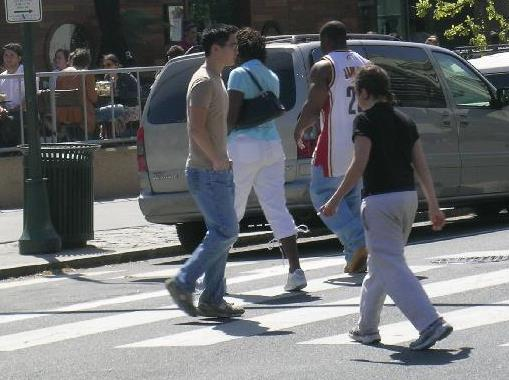

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

## Question 4 (5 pts)
Given mask of an object, colorize the mask.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings

"""
Given a mask for an object, return coloured mask. Shape of the given mask is
(H, W), so the shape of returned mask should be (3, H, W).
"""
def get_coloured_mask(mask):
    coloured_mask = None
    ##################################################################
    ###                      YOUR CODE STARTS                      ###
    ##################################################################

    # TODO: Assign a color to the given mask. Bonus: assign distinct colors to
    # each mask

    # TODO: Masks you receive might contain noise, so apply a threshold.
    #mask[mask < 0] = 0
    random_colors = np.random.rand(3, 1, 1)
    coloured_mask = (random_colors * mask).astype(np.uint8)




    ##################################################################
    ###                       YOUR CODE ENDS                       ###
    ##################################################################

    return coloured_mask

## Question 5 (7.5 pts)
Visualize the image, masks, and bounding boxes. You can expect non-perfect masks.  

Optional: If you want better masks, change your training strategy! (changing # of epochs, different optimizer etc.)

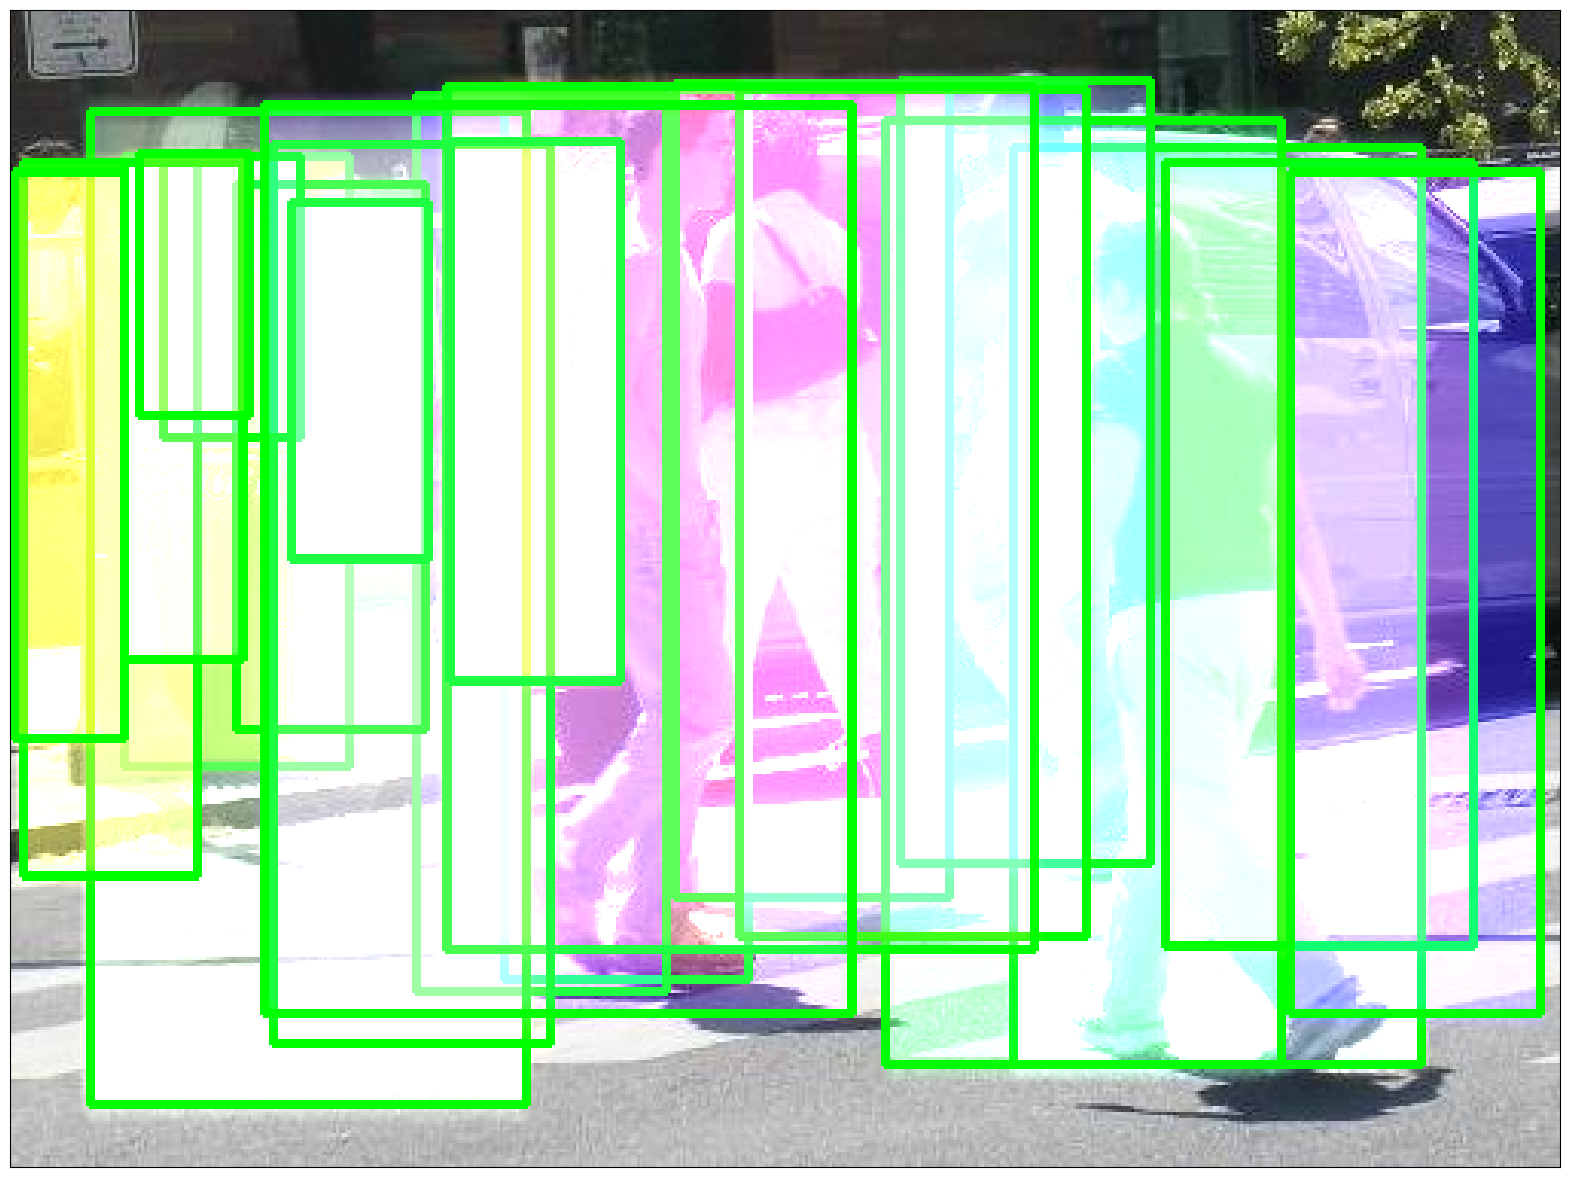

In [ ]:
%matplotlib inline

def vis_instance(img, prediction):
    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    scores = prediction[0]['scores'].tolist()
    for i in range(len(scores)):
      box = prediction[0]['boxes'][i].cpu().numpy()
      mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
      rgb_mask = get_coloured_mask(mask)
      ##################################################################
      ###                      YOUR CODE STARTS                      ###
      ##################################################################
      # TODO: Add image and RGB mask on top of each other. Hint: check cv2
      # operations (cv2.addWeighted)
      rgb_mask = rgb_mask.transpose(1, 2, 0)
      img = cv2.addWeighted(img, 1.0 ,rgb_mask, 1, 0)
      # TODO: Add a rectangle around the instances. Hint: check cv2 drawing
      # functions (cv2.rectangle)

      cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)



      ##################################################################
      ###                       YOUR CODE ENDS                       ###
      ##################################################################
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

vis_instance(img, prediction)

## D) Bird's Eye-View Questions (10 pts)

## Question 1 (5 pts)
Why is the bird's eye view representation the most common representation in autonomous driving? What are the advantages and disadvantages compared to using a representation in pixel space? Discuss this.

You can check the Introduction parts of the following papers: [SimpleBEV [14]](https://arxiv.org/pdf/2206.07959.pdf), [BEVFormer [15]](https://arxiv.org/pdf/2203.17270.pdf )

**Answer:**

## Question 2 (5 pts)

- When forming a Bird's Eye View (BEV) representation of a scene from camera images, what are we trying to recover?
  
  **Answer**:

- What are the main challenges of BEV methods?
 In which cases these methods likely to fail?

  You can refer to Introduction and Related Work parts of the papers.

  [SimpleBEV [14]](https://arxiv.org/pdf/2206.07959.pdf), [BEVFormer [15]](https://arxiv.org/pdf/2203.17270.pdf), [PointBEV [16]](https://arxiv.org/pdf/2312.00703.pdf)


  **Answer**:



# References

[1] J. Long, E. Shelhamer, and T. Darrell. Fully Convolutional Networks for Semantic Segmentation. CVPR, 2015.

[2] V. Badrinarayanan, A. Kendall, and R. Cipolla. Fully Convolutional Networks for Semantic Segmentation. PAMI, 2017.

[3] O. Ronneberger, P. Fischer, and T. Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. MICCAI, 2015.

[4] Checkerboard artifacts [https://distill.pub/2016/deconv-checkerboard/]

[5] A survey of loss functions for semantic segmentation [https://arxiv.org/pdf/2006.14822.pdf].

[6] K. He, G. Gkioxari, P. Dollar, and R. Girshick. Mask R-CNN. ICCV, 2017.   

[7] https://www.cis.upenn.edu/~jshi/ped_html/  

[8] J. Dai, K. He, and J. Sun. Instance-aware Semantic Segmentation via Multi-task Network Cascades. CVPR, 2016.  

[9] R. Girshick. Fast R-CNN. ICCV, 2015.   

[10] J. Long, E. Shelhamer, and T. Darrell. Fully convolutional networks for semantic segmentation. CVPR, 2015.   

[11] D. Bolya, C. Zhou, F. Xiao, Y. Jae Lee. YOLACT: Real-time Instance Segmentation. ICCV, 2019

[12] Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. S. Ren, K. He, R. Girshick, J. Sun. NIPS, 2015    

[13] https://d2l.ai/chapter_computer-vision/bounding-box.html#bounding-box

[14] Harley, Adam W., et al. "Simple-bev: What really matters for multi-sensor bev perception?." 2023 IEEE International Conference on Robotics and Automation (ICRA). IEEE, 2023.

[15] Li, Zhiqi, et al. "Bevformer: Learning bird’s-eye-view representation from multi-camera images via spatiotemporal transformers." European conference on computer vision. Cham: Springer Nature Switzerland, 2022.

[16] Chambon, Loick, et al. "PointBeV: A Sparse Approach to BeV Predictions." arXiv preprint arXiv:2312.00703 (2023).